# WRAP UP QUIZ
## Question 1
`penguins` is a pandas dataframe. The column "Species" contains the target variable. We extract the numerical columns that quantify some attributes of such animals and our goal is try to predict their species based on those attributes stored in the dataframe named `data`.

In [1]:
import pandas as pd

url = "https://raw.githubusercontent.com/INRIA/scikit-learn-mooc/master/datasets/penguins.csv"
penguins = pd.read_csv(url)

columns = ["Body Mass (g)", "Flipper Length (mm)", "Culmen Length (mm)"]
target_name = "Species"

# Remove lines with missing values for the columns of interest
penguins_non_missing = penguins[columns + [target_name]].dropna()

data = penguins_non_missing[columns]
target = penguins_non_missing[target_name]

In [5]:
target.value_counts()

Species
Adelie Penguin (Pygoscelis adeliae)          151
Gentoo penguin (Pygoscelis papua)            123
Chinstrap penguin (Pygoscelis antarctica)     68
Name: count, dtype: int64

We observe that there are 3 classes, thus the problem is a multiclass problem.

## Question 2
Inspect the statistics of the target and individual features

In [9]:
data.describe()

,Body Mass (g),Flipper Length (mm),Culmen Length (mm)
count,342.000000,342.000000,342.000000
mean,4201.754386,200.915205,43.921930
std,801.954536,14.061714,5.459584
min,2700.000000,172.000000,32.100000
25%,3550.000000,190.000000,39.225000
50%,4050.000000,197.000000,44.450000
75%,4750.000000,213.000000,48.500000
max,6300.000000,231.000000,59.600000


In [11]:
target.describe()

count                                     342
unique                                      3
top       Adelie Penguin (Pygoscelis adeliae)
freq                                      151
Name: Species, dtype: object

The proportions of the class counts are imbalanced: some classes have more than twice as many rows than others

## Question 3
Evaluate the pipeline using stratified 10-fold cross-validation with the balanced-accuracy scoring metric to choose the correct statement in the list below.
You can use:
- `sklearn.model_selection.cross_validate` to perform the cross-validation routine;
- provide an integer 10 to the parameter `cv` of `cross_validate` to use the cross-validation with 10 folds;
- provide the string "`balanced_accuracy`" to the parameter `scoring` of `cross_validate`.

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
model = Pipeline(steps=[
    ("preprocessor", StandardScaler()),
    ("classifier", KNeighborsClassifier(n_neighbors=5)),
])

In [14]:
from sklearn.model_selection import cross_validate
cv_results = cross_validate(model, data, target, cv=10, scoring="balanced_accuracy")
test_score = cv_results["test_score"]
print(f"Test accuracy score: {test_score.mean():.3f} +/- {test_score.std():.3f}")

Test accuracy score: 0.952 +/- 0.040


## Question 4
Repeat the evaluation by setting the parameters in order to select the correct statements in the list below. We recall that you can use `model.get_params() `to list the parameters of the pipeline and use `model.set_params(param_name=param_value)` to update them. Remember that one way to compare two models is comparing the cross-validation test scores of both models fold-to-fold, i.e. counting the number of folds where one model has a better test score than the other.

In [17]:
model.get_params()

{'memory': None,
 'steps': [('preprocessor', StandardScaler()),
  ('classifier', KNeighborsClassifier())],
 'transform_input': None,
 'verbose': False,
 'preprocessor': StandardScaler(),
 'classifier': KNeighborsClassifier(),
 'preprocessor__copy': True,
 'preprocessor__with_mean': True,
 'preprocessor__with_std': True,
 'classifier__algorithm': 'auto',
 'classifier__leaf_size': 30,
 'classifier__metric': 'minkowski',
 'classifier__metric_params': None,
 'classifier__n_jobs': None,
 'classifier__n_neighbors': 5,
 'classifier__p': 2,
 'classifier__weights': 'uniform'}

In [28]:
model.set_params(classifier__n_neighbors=5)
cv_results_ss_5 = cross_validate(model, data, target, cv=10, scoring="balanced_accuracy")
cv_results_ss_5["test_score"].mean()

np.float64(0.9521978021978021)

In [29]:
model.set_params(classifier__n_neighbors=51)
cv_results_ss_51 = cross_validate(model, data, target, cv=10, scoring="balanced_accuracy")
cv_results_ss_51["test_score"].mean()

np.float64(0.9418803418803419)

In [30]:
model.set_params(classifier__n_neighbors=101)
cv_results_ss_101 = cross_validate(model, data, target, cv=10, scoring="balanced_accuracy")
cv_results_ss_101["test_score"].mean()

np.float64(0.8766422466422465)

We observe that the average test accuracy of this last model seems to be substantially lower that the previous models. Let's check the number of CV folds where this is actually the case:

It is possible to change the pipeline parameters and re-run a cross-validation with: `classifier__n_neighbors = 51` which gives slightly worse test scores but the difference is not necessarily significant: they overlap a lot. So given the definition of better, we can check the individual score for each fold and count how many times the 5-NN classifier is better than the 51-NN classifier. With some python code (you could have do it by visualizing the "test_score" columns as well), we obtain:

In [31]:
model.set_params(preprocessor=StandardScaler(), classifier__n_neighbors=51)
cv_results_ss_51 = cross_validate(
    model, data, target, cv=10, scoring="balanced_accuracy"
)
cv_results_ss_51["test_score"].mean(), cv_results_ss_51["test_score"].std()
      

(np.float64(0.9418803418803419), np.float64(0.03890547525064432))

5-NN is strictly better than 51-NN for 4 CV iterations out of 10.


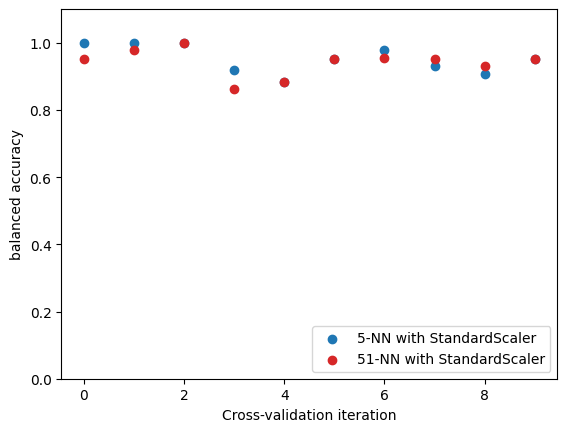

In [32]:
import numpy as np
import matplotlib.pyplot as plt

test_score_ss_5 = cv_results_ss_5['test_score']
test_score_ss_51 = cv_results_ss_51['test_score']

indices = np.arange(len(test_score_ss_5))
plt.scatter(
    indices,
    test_score_ss_5,
    color="tab:blue",
    label="5-NN with StandardScaler",
)
plt.scatter(
    indices,
    test_score_ss_51,
    color="tab:red",
    label="51-NN with StandardScaler",
)
plt.ylim((0, 1.1))
plt.xlabel("Cross-validation iteration")
plt.ylabel("balanced accuracy")
_ = plt.legend(loc="lower right")

print(
    "5-NN is strictly better than 51-NN for "
    f"{sum(test_score_ss_5 > test_score_ss_51)}"
    " CV iterations out of 10."
)

Here, 5-NN is strictly better than 51-NN only 4 times and thus we cannot conclude that it is substantially better.

5-NN is strictly better than 51-NN for 10 CV iterations out of 10.


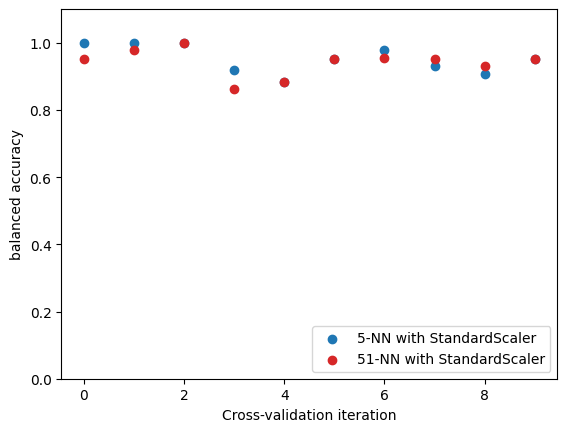

In [33]:
test_score_ss_101 = cv_results_ss_101['test_score']

indices = np.arange(len(test_score_ss_5))
plt.scatter(
    indices,
    test_score_ss_5,
    color="tab:blue",
    label="5-NN with StandardScaler",
)
plt.scatter(
    indices,
    test_score_ss_51,
    color="tab:red",
    label="51-NN with StandardScaler",
)
plt.ylim((0, 1.1))
plt.xlabel("Cross-validation iteration")
plt.ylabel("balanced accuracy")
_ = plt.legend(loc="lower right")

print(
    "5-NN is strictly better than 51-NN for "
    f"{sum(test_score_ss_5 > test_score_ss_101)}"
    " CV iterations out of 10."
)

In this case, we observe that 5-NN is always better.
We can disable the preprocessor by setting the `preprocessor` parameter to `None` (while resetting the number of neighbors to 5) as follows:

In [34]:
model.set_params(preprocessor=None, classifier__n_neighbors=5)
cv_results_none_5 = cross_validate(
    model, data, target, cv=10, scoring="balanced_accuracy"
)
cv_results_none_5["test_score"].mean(), cv_results_none_5["test_score"].std()

(np.float64(0.7398382173382173), np.float64(0.08668489381180364))

This gives results with a mean balanced accuracy of ~0.74 which is much worse than the same result with preprocessing enabled. We can confirm that preprocessing the dataset lead to a substantially better model:

5-NN with scaling is better than 5-NN without scaling for 10 CV iterations out of 10.


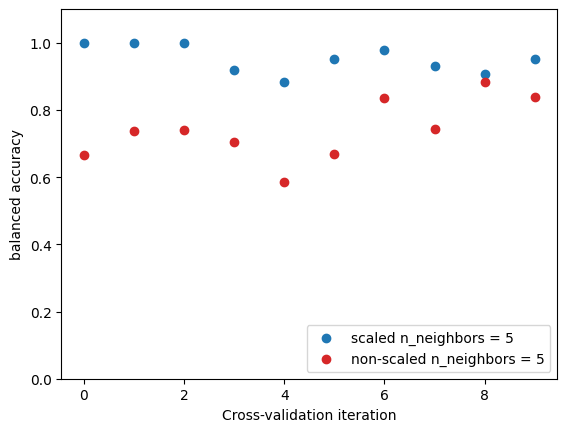

In [35]:
test_score_none_5 = cv_results_none_5['test_score']

plt.scatter(
    indices, test_score_ss_5, color="tab:blue", label="scaled n_neighbors = 5"
)
plt.scatter(
    indices,
    test_score_none_5,
    color="tab:red",
    label="non-scaled n_neighbors = 5",
)
plt.ylim((0, 1.1))
plt.xlabel("Cross-validation iteration")
plt.ylabel("balanced accuracy")
_ = plt.legend(loc="lower right")

print(
    "5-NN with scaling is better than 5-NN without scaling for "
    f"{sum(test_score_ss_5 > test_score_none_5)}"
    " CV iterations out of 10."
)

Here, the model with feature scaling is performing better 10 times over 10 than the model that does not preprocess the dataset

## Question 5

We will now study the impact of different preprocessors defined in the list below:

In [36]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer


all_preprocessors = [
    None,
    StandardScaler(),
    MinMaxScaler(),
    QuantileTransformer(n_quantiles=100),
    PowerTransformer(method="box-cox"),
]

In [45]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "preprocessor": all_preprocessors,
    "classifier__n_neighbors": [5, 51, 101],
}

grid_search = GridSearchCV(
    model,
    param_grid=param_grid,
    scoring="balanced_accuracy",
    cv=10,
).fit(data, target)
results = pd.DataFrame(grid_search.cv_results_).sort_values(
    by="rank_test_score", ascending=True
)
# convert the name of the preprocessor for later display
results["param_preprocessor"] = results["param_preprocessor"].apply(
    lambda x: x.__class__.__name__ if x is not None else "None"
)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__n_neighbors,param_preprocessor,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
1,0.002620,0.000425,0.003500,0.000416,5,StandardScaler,"{'classifier__n_neighbors': 5, 'preprocessor':...",1.000000,1.000000,1.000000,0.918803,0.882540,0.952381,0.977778,0.930159,0.907937,0.952381,0.952198,0.039902,1
2,0.002358,0.000344,0.003330,0.000315,5,MinMaxScaler,"{'classifier__n_neighbors': 5, 'preprocessor':...",1.000000,0.952381,1.000000,0.944444,0.882540,0.930159,0.955556,0.952381,0.907937,0.952381,0.947778,0.034268,2
3,0.003021,0.000276,0.003405,0.000304,5,QuantileTransformer,"{'classifier__n_neighbors': 5, 'preprocessor':...",0.952381,0.926740,1.000000,0.918803,0.904762,1.000000,0.977778,0.930159,0.907937,0.952381,0.947094,0.033797,3
4,0.017582,0.003881,0.004148,0.000429,5,PowerTransformer,"{'classifier__n_neighbors': 5, 'preprocessor':...",1.000000,0.977778,1.000000,0.863248,0.882540,0.952381,0.955556,0.930159,0.907937,1.000000,0.946960,0.047387,4
6,0.002330,0.000604,0.003364,0.000497,51,StandardScaler,"{'classifier__n_neighbors': 51, 'preprocessor'...",0.952381,0.977778,1.000000,0.863248,0.882540,0.952381,0.955556,0.952381,0.930159,0.952381,0.941880,0.038905,5
8,0.003837,0.000839,0.004282,0.000301,51,QuantileTransformer,"{'classifier__n_neighbors': 51, 'preprocessor'...",0.857143,0.952381,1.000000,0.863248,0.904762,0.904762,0.977778,0.930159,0.930159,0.952381,0.927277,0.043759,6
9,0.021223,0.003746,0.004581,0.000641,51,PowerTransformer,"{'classifier__n_neighbors': 51, 'preprocessor'...",0.904762,0.977778,1.000000,0.863248,0.834921,0.952381,0.907937,0.952381,0.930159,0.904762,0.922833,0.047883,7
7,0.001953,0.000262,0.003090,0.000479,51,MinMaxScaler,"{'classifier__n_neighbors': 51, 'preprocessor'...",0.904762,0.952381,1.000000,0.863248,0.834921,0.952381,0.907937,0.952381,0.930159,0.904762,0.920293,0.045516,8
11,0.002068,0.000117,0.003268,0.000269,101,StandardScaler,"{'classifier__n_neighbors': 101, 'preprocessor...",0.857143,0.952381,0.944444,0.863248,0.834921,0.857143,0.834921,0.882540,0.834921,0.904762,0.876642,0.041618,9
12,0.001990,0.000302,0.003321,0.000532,101,MinMaxScaler,"{'classifier__n_neighbors': 101, 'preprocessor...",0.857143,0.857143,0.944444,0.863248,0.834921,0.857143,0.765079,0.904762,0.834921,0.904762,0.862357,0.046244,10


In [46]:
from sklearn.model_selection import GridSearchCV

model_gs = GridSearchCV(model, param_grid = {'preprocessor':all_preprocessors, 'classifier__n_neighbors': [5, 51, 101]}, scoring = 'balanced_accuracy', cv=10)
model_gs.fit(data, target)
results = pd.DataFrame(model_gs.cv_results_).sort_values(by='rank_test_score', ascending=True)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__n_neighbors,param_preprocessor,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
1,0.001738,0.000182,0.002522,0.000458,5,StandardScaler(),"{'classifier__n_neighbors': 5, 'preprocessor':...",1.000000,1.000000,1.000000,0.918803,0.882540,0.952381,0.977778,0.930159,0.907937,0.952381,0.952198,0.039902,1
2,0.001916,0.000376,0.002700,0.000444,5,MinMaxScaler(),"{'classifier__n_neighbors': 5, 'preprocessor':...",1.000000,0.952381,1.000000,0.944444,0.882540,0.930159,0.955556,0.952381,0.907937,0.952381,0.947778,0.034268,2
3,0.002668,0.000240,0.003003,0.000290,5,QuantileTransformer(n_quantiles=100),"{'classifier__n_neighbors': 5, 'preprocessor':...",0.952381,0.926740,1.000000,0.918803,0.904762,1.000000,0.977778,0.930159,0.907937,0.952381,0.947094,0.033797,3
4,0.023347,0.010471,0.004654,0.001718,5,PowerTransformer(method='box-cox'),"{'classifier__n_neighbors': 5, 'preprocessor':...",1.000000,0.977778,1.000000,0.863248,0.882540,0.952381,0.955556,0.930159,0.907937,1.000000,0.946960,0.047387,4
6,0.001946,0.000160,0.003055,0.000474,51,StandardScaler(),"{'classifier__n_neighbors': 51, 'preprocessor'...",0.952381,0.977778,1.000000,0.863248,0.882540,0.952381,0.955556,0.952381,0.930159,0.952381,0.941880,0.038905,5
8,0.002768,0.000323,0.003163,0.000235,51,QuantileTransformer(n_quantiles=100),"{'classifier__n_neighbors': 51, 'preprocessor'...",0.857143,0.952381,1.000000,0.863248,0.904762,0.904762,0.977778,0.930159,0.930159,0.952381,0.927277,0.043759,6
9,0.017185,0.001860,0.003989,0.000340,51,PowerTransformer(method='box-cox'),"{'classifier__n_neighbors': 51, 'preprocessor'...",0.904762,0.977778,1.000000,0.863248,0.834921,0.952381,0.907937,0.952381,0.930159,0.904762,0.922833,0.047883,7
7,0.001963,0.000337,0.002857,0.000328,51,MinMaxScaler(),"{'classifier__n_neighbors': 51, 'preprocessor'...",0.904762,0.952381,1.000000,0.863248,0.834921,0.952381,0.907937,0.952381,0.930159,0.904762,0.920293,0.045516,8
11,0.002267,0.000454,0.003514,0.000344,101,StandardScaler(),"{'classifier__n_neighbors': 101, 'preprocessor...",0.857143,0.952381,0.944444,0.863248,0.834921,0.857143,0.834921,0.882540,0.834921,0.904762,0.876642,0.041618,9
12,0.003084,0.000720,0.004206,0.000352,101,MinMaxScaler(),"{'classifier__n_neighbors': 101, 'preprocessor...",0.857143,0.857143,0.944444,0.863248,0.834921,0.857143,0.765079,0.904762,0.834921,0.904762,0.862357,0.046244,10


We see that the best model uses a StandardScaler while the subsequent three models are using the other preprocessors. We can thus check if StandardScaler is performing substantially better than the other models.

5-NN with StandardScaler() is strictly better than 5-NN with MinMaxScaler() for 3 CV iterations out of 10.
5-NN with StandardScaler() is strictly better than 5-NN with QuantileTransformer(n_quantiles=100) for 2 CV iterations out of 10.
5-NN with StandardScaler() is strictly better than 5-NN with PowerTransformer(method='box-cox') for 3 CV iterations out of 10.


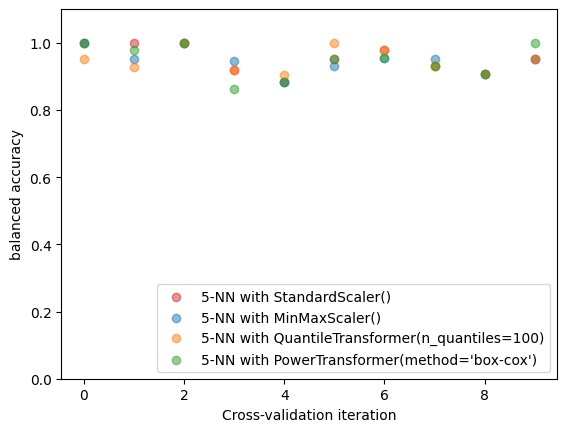

In [47]:
reference_model = results.iloc[0] # get the first row which is the best model
other_models = results.iloc[1:4] # get the 3 subsequent models
cv_score_columns = results.columns[results.columns.str.startswith("split")] # get the columns with the cross-validation results
score_reference_model = reference_model[cv_score_columns] # get the cross-validation results of the reference model


fig, ax = plt.subplots()
ax.scatter(
    indices,
    score_reference_model,
    color="tab:red",
    alpha=0.5,
    label=f"{reference_model['param_classifier__n_neighbors']}-NN with "
          f"{reference_model['param_preprocessor']}",
)

for idx, other_model in other_models.iterrows():
    score_other_model = other_model[cv_score_columns]
    ax.scatter(
    indices,
    score_other_model,
    alpha=0.5,
    label=f"{other_model['param_classifier__n_neighbors']}-NN with "
          f"{other_model['param_preprocessor']}",
    )
    print(
        f"{reference_model['param_classifier__n_neighbors']}-NN with "
        f"{reference_model['param_preprocessor']} is strictly better than "
        f"{other_model['param_classifier__n_neighbors']}-NN with "
        f"{other_model['param_preprocessor']} for "
        f"{sum(score_reference_model > score_other_model)} CV iterations "
        f"out of 10."
    )
ax.set_ylim((0, 1.1))
ax.set_xlabel("Cross-validation iteration")
ax.set_ylabel("balanced accuracy")
_ = ax.legend(loc="lower right")

A 5-NN model with a StandardScaler does not perform substantially better than the models that use alternative scaling strategies. Looking at the ranking, we see that not applying any preprocessing always lead to the worst results. The main reason that explains that removing the preprocessor leads to bad performance, is the fact that the input features have very different dynamic ranges when using the default units (grams and millimeters).

Now, we can fix the preprocessor to StandardScaler and check the impact of the number of neighbors on the score and conclude on the item c):

5-NN with StandardScaler is strictly better than 51-NN with StandardScaler for 4  CV iterations out of 10.


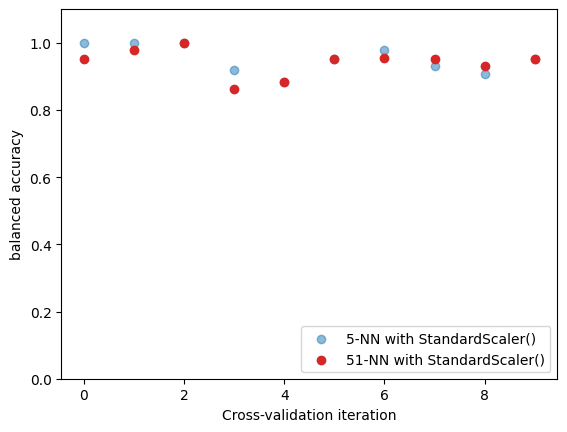

In [48]:
model_ss_51 = results.iloc[4]
score_model_ss_51 = model_ss_51[cv_score_columns]

fig, ax = plt.subplots()
ax.scatter(
    indices,
    score_reference_model,
    color="tab:blue",
    alpha=0.5,
    label=f"{reference_model['param_classifier__n_neighbors']}-NN with "
          f"{reference_model['param_preprocessor']}",
)
ax.scatter(
    indices,
    score_model_ss_51,
    color="tab:red",
    label=f"{model_ss_51['param_classifier__n_neighbors']}-NN with "
          f"{model_ss_51['param_preprocessor']}",
)
plt.ylim((0,1.1))
plt.xlabel("Cross-validation iteration")
plt.ylabel("balanced accuracy")
_=plt.legend(loc="lower right")
print(
    f"5-NN with StandardScaler is strictly better than 51-NN with StandardScaler for "
    f"{sum(score_reference_model > score_model_ss_51)}  CV iterations out of 10."
)

5-NN is not substantially better 51-NN when the preprocessor is fixed to a StandardScaler. We can repeat the same process to compare the 51-NN and 101-NN

51-NN with StandardScaler is strictly better than 101-NN with StandardScaler for 9  CV iterations out of 10.


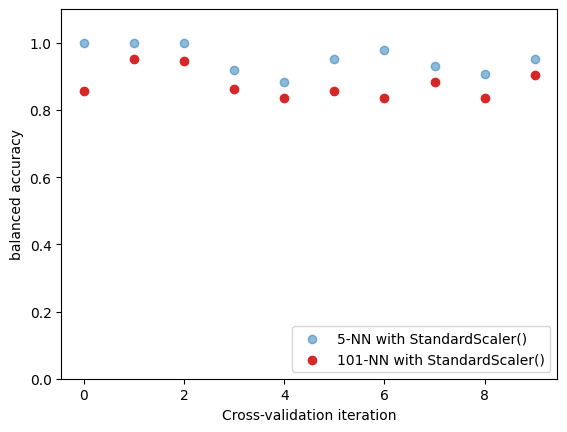

In [49]:
model_ss_101 = results.iloc[8]
score_model_101 = model_ss_101[cv_score_columns]

fig, ax = plt.subplots()
ax.scatter(
    indices,
    score_reference_model,
    color="tab:blue",
    alpha=0.5,
    label=f"{reference_model['param_classifier__n_neighbors']}-NN with "
          f"{reference_model['param_preprocessor']}",
)
ax.scatter(
    indices,
    score_model_101,
    color="tab:red",
    label=f"{model_ss_101['param_classifier__n_neighbors']}-NN with "
          f"{model_ss_101['param_preprocessor']}",
)
plt.ylim((0,1.1))
plt.xlabel("Cross-validation iteration")
plt.ylabel("balanced accuracy")
_=plt.legend(loc="lower right")

print(
    f"51-NN with StandardScaler is strictly better than 101-NN with StandardScaler for "
    f"{sum(score_model_ss_51 > score_model_101)}  CV iterations out of 10.")

In this case, we observe that 51-NN is substantially better than the 101-NN.

As explained previously, setting a too large value for n_neighbors causes under-fitting. Here the data is well structured and has not much noise: using low values for n_neighbors is as good or better than intermediate values as there is not much over-fitting possible.

## Question 6

Evaluate the generalization performance of the best models found in each folding using nested cv. Set `return_estimator=True` and `cv=10 `for the outer loop. The scoring metric must be the `balanced-accuracy`

In [51]:
from sklearn.model_selection import cross_validate

# Define the outer cross-validation
outer_cv_results = cross_validate(
    grid_search, 
    data, 
    target, 
    cv=10, 
    scoring="balanced_accuracy", 
    return_estimator=True
)

# Extract the test scores from the outer cross-validation
outer_test_scores = outer_cv_results["test_score"]

# Print the mean and standard deviation of the test scores
print(f"Generalization score with hyperparameters tuning : \n"
      f"{outer_test_scores.mean():.3f} +/- {outer_test_scores.std():.3f}")

Generalization score with hyperparameters tuning : 
0.943 +/- 0.036


## Question 7

Explore the set of best parameters that the different grid search models found in each fold of the outer cross validation. Remember that you can access them with the `best_params_` attribute of the estimator. 

In [54]:
for estimator in outer_cv_results["estimator"]:
    print(estimator.best_params_)


{'classifier__n_neighbors': 5, 'preprocessor': QuantileTransformer(n_quantiles=100)}
{'classifier__n_neighbors': 5, 'preprocessor': QuantileTransformer(n_quantiles=100)}
{'classifier__n_neighbors': 5, 'preprocessor': StandardScaler()}
{'classifier__n_neighbors': 5, 'preprocessor': StandardScaler()}
{'classifier__n_neighbors': 5, 'preprocessor': MinMaxScaler()}
{'classifier__n_neighbors': 5, 'preprocessor': QuantileTransformer(n_quantiles=100)}
{'classifier__n_neighbors': 5, 'preprocessor': MinMaxScaler()}
{'classifier__n_neighbors': 5, 'preprocessor': StandardScaler()}
{'classifier__n_neighbors': 5, 'preprocessor': StandardScaler()}
{'classifier__n_neighbors': 5, 'preprocessor': QuantileTransformer(n_quantiles=100)}


In [52]:
# Extract the best parameters from each fold of the outer cross-validation
best_params_per_fold = [estimator.best_params_ for estimator in outer_cv_results['estimator']]

# Display the best parameters for each fold
for fold_idx, params in enumerate(best_params_per_fold):
    print(f"Fold {fold_idx + 1}: {params}")

Fold 1: {'classifier__n_neighbors': 5, 'preprocessor': QuantileTransformer(n_quantiles=100)}
Fold 2: {'classifier__n_neighbors': 5, 'preprocessor': QuantileTransformer(n_quantiles=100)}
Fold 3: {'classifier__n_neighbors': 5, 'preprocessor': StandardScaler()}
Fold 4: {'classifier__n_neighbors': 5, 'preprocessor': StandardScaler()}
Fold 5: {'classifier__n_neighbors': 5, 'preprocessor': MinMaxScaler()}
Fold 6: {'classifier__n_neighbors': 5, 'preprocessor': QuantileTransformer(n_quantiles=100)}
Fold 7: {'classifier__n_neighbors': 5, 'preprocessor': MinMaxScaler()}
Fold 8: {'classifier__n_neighbors': 5, 'preprocessor': StandardScaler()}
Fold 9: {'classifier__n_neighbors': 5, 'preprocessor': StandardScaler()}
Fold 10: {'classifier__n_neighbors': 5, 'preprocessor': QuantileTransformer(n_quantiles=100)}
